<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/XGBoost_ML_Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preview:
   Lactate Level  Blood Pressure  Age  White Blood Cell Count   Outcome
0       3.309051      143.779406   64                7.229655    Stable
1       7.630357      124.331564   29               14.774919    Stable
2       5.989955       97.143314   79               19.518593    Stable
3       4.989939      157.655402   25                5.502411    Stable
4       1.670140      142.167741   38               14.761634  Critical

Dataset Shape: (500, 5)
Outcome Distribution:
Outcome
Stable      329
Critical    171
Name: count, dtype: int64

Training samples: 400
Testing samples: 100

Training XGBoost model...
✓ Training complete!

MODEL ACCURACY: 59.00%

Detailed Performance Report:
              precision    recall  f1-score   support

    Critical       0.23      0.09      0.13        34
      Stable       0.64      0.85      0.73        66

    accuracy                           0.59       100
   macro avg       0.44      0.47      0.43       100
weighted avg       0.50

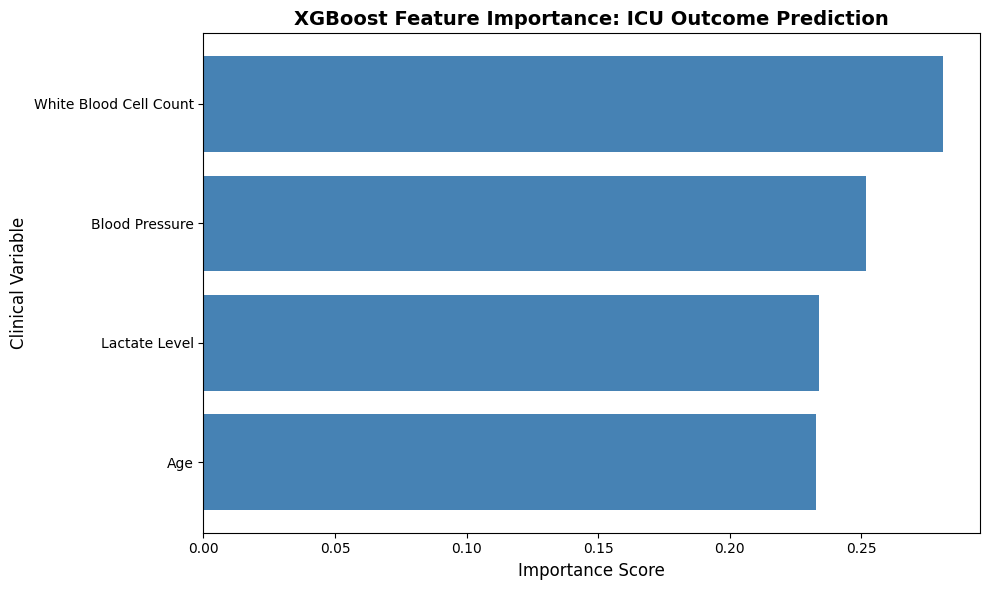


Example: Predict Outcome for a New Patient

Patient Profile:
 Lactate Level  Blood Pressure  Age  White Blood Cell Count
           4.5              85   67                    15.2

Predicted Outcome: Stable
Model Confidence: 65.2%


In [1]:
# ============================================
# ICU Patient Outcome Prediction with XGBoost
# ============================================

# Install XGBoost (run this first in Colab)
!pip install xgboost

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

# ============================================
# STEP 1: Load Your Data
# ============================================
# Replace 'your_file.csv' with your actual file path
# Or upload via: from google.colab import files; uploaded = files.upload()

# For demonstration, I'll create sample data (remove this when using your real CSV)
np.random.seed(42)
n_samples = 500

sample_data = pd.DataFrame({
    'Lactate Level': np.random.uniform(0.5, 8.0, n_samples),
    'Blood Pressure': np.random.uniform(60, 180, n_samples),
    'Age': np.random.randint(18, 90, n_samples),
    'White Blood Cell Count': np.random.uniform(4, 20, n_samples),
    'Outcome': np.random.choice(['Stable', 'Critical'], n_samples, p=[0.65, 0.35])
})

# When using your actual CSV, uncomment this line:
# df = pd.read_csv('your_file.csv')
df = sample_data  # Remove this line when using real data

print("Data Preview:")
print(df.head())
print(f"\nDataset Shape: {df.shape}")
print(f"Outcome Distribution:\n{df['Outcome'].value_counts()}")

# ============================================
# STEP 2: Prepare Data for Machine Learning
# ============================================
# Separate features (X) and target (y)
X = df[['Lactate Level', 'Blood Pressure', 'Age', 'White Blood Cell Count']]
y = df['Outcome']

# Convert text outcomes to numbers (Stable=0, Critical=1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# ============================================
# STEP 3: Train the XGBoost Model
# ============================================
model = xgb.XGBClassifier(
    max_depth=3,              # Prevents overfitting
    learning_rate=0.1,        # How fast the model learns
    n_estimators=100,         # Number of decision trees
    random_state=42,
    eval_metric='logloss'
)

print("\nTraining XGBoost model...")
model.fit(X_train, y_train)
print("✓ Training complete!")

# ============================================
# STEP 4: Evaluate Model Performance
# ============================================
# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n{'='*50}")
print(f"MODEL ACCURACY: {accuracy:.2%}")
print(f"{'='*50}")

# Detailed classification report
print("\nDetailed Performance Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"                Predicted Stable  Predicted Critical")
print(f"Actually Stable        {cm[0,0]:>6}          {cm[0,1]:>6}")
print(f"Actually Critical      {cm[1,0]:>6}          {cm[1,1]:>6}")

# ============================================
# STEP 5: Feature Importance (Which Labs Matter Most?)
# ============================================
print(f"\n{'='*50}")
print("FEATURE IMPORTANCE (Which Labs Matter Most?)")
print(f"{'='*50}")

# Get feature importance scores
importance_scores = model.feature_importances_
features = X.columns

# Create a sorted list
importance_df = pd.DataFrame({
    'Clinical Variable': features,
    'Importance Score': importance_scores
}).sort_values('Importance Score', ascending=False)

print("\nRanked by Predictive Power:")
for idx, row in importance_df.iterrows():
    bar = '█' * int(row['Importance Score'] * 50)
    print(f"{row['Clinical Variable']:25} {bar} {row['Importance Score']:.3f}")

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Clinical Variable'], importance_df['Importance Score'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Clinical Variable', fontsize=12)
plt.title('XGBoost Feature Importance: ICU Outcome Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================
# STEP 6: Test with a New Patient (Optional)
# ============================================
print("\n" + "="*50)
print("Example: Predict Outcome for a New Patient")
print("="*50)

new_patient = pd.DataFrame({
    'Lactate Level': [4.5],
    'Blood Pressure': [85],
    'Age': [67],
    'White Blood Cell Count': [15.2]
})

prediction = model.predict(new_patient)
prediction_proba = model.predict_proba(new_patient)

outcome = label_encoder.inverse_transform(prediction)[0]
confidence = prediction_proba[0][prediction[0]] * 100

print(f"\nPatient Profile:")
print(new_patient.to_string(index=False))
print(f"\nPredicted Outcome: {outcome}")
print(f"Model Confidence: {confidence:.1f}%")